Setting up PySpark in Colab

In [ ]:

!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

--2022-05-19 22:22:07--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  27.9MB/s    in 11s     

2022-05-19 22:22:19 (24.1 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

Now that we have installed all the necessary dependencies in Colab, it is time to set the environment path. This will enable us to run Pyspark in the Colab environment.

In [ ]:
import pyspark
import numpy as np
import pandas as pd

# Problem description
A model to create clustering with flamingo datatset, identifyiny big or small buyers. 

Data Preparation
Removing columns and rows
Import needed dataset from github


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master('local[*]').appName('Buyers').getOrCreate()

# Read data from CSV file
#you can download it from here: https://raw.githubusercontent.com/besherh/BigDataManagement/main/SparkCSV/flights-larger.csv
df = spark.read.csv('combined-data.csv', sep=',', header=True, inferSchema=True, nullValue='NULL')
#df = pd.read_csv("combined-data.csv")



In [ ]:
#View table structure
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: integer (nullable = true)
 |-- avg_price: double (nullable = true)



In [ ]:
#Total number of records
df.count()


4619

In [ ]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col,isnan, when, count

In [ ]:
#Check for missing values
#
df.na.drop().count()


1411

In [ ]:
df.na.drop(how="any", thresh=2).show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|
+------+-------------+---------+------------+----------------+----------+-----------+---------+
|   812|         5648|        1|     android|              69|         8|       null|     null|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|
|  1863|         5651|        1|     android|              35|         4|       null|     null|
|   937|         5652|        1|     android|              39|         0|          1|      1.0|
|   342|         5653|        1|     android|              36|         5|       null|     null|
|   849|         5654|        1|      iphone|              40|         5|       null|     null|
|  1277|         5655|        1|     win

Fill missing values with mean of column


In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=['count_buyId', 'avg_price'], 
    outputCols=["{}_imputed".format(c) for c in ['count_buyId', 'avg_price']]
    ).setStrategy("median")

In [ ]:
# Add imputation cols to df
df2 = imputer.fit(df).transform(df)

In [ ]:
df2.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|count_buyId_imputed|avg_price_imputed|
+------+-------------+---------+------------+----------------+----------+-----------+---------+-------------------+-----------------+
|   812|         5648|        1|     android|              69|         8|       null|     null|                  1|              3.5|
|  1658|         5649|        1|      iphone|              31|         5|       null|     null|                  1|              3.5|
|  1589|         5650|        1|      iphone|              26|         2|       null|     null|                  1|              3.5|
|  1863|         5651|        1|     android|              35|         4|       null|     null|                  1|              3.5|
|   937|         5652|        1|     android|              39|

In [ ]:
df2.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- teamLevel: integer (nullable = true)
 |-- platformType: string (nullable = true)
 |-- count_gameclicks: integer (nullable = true)
 |-- count_hits: integer (nullable = true)
 |-- count_buyId: integer (nullable = true)
 |-- avg_price: double (nullable = true)
 |-- count_buyId_imputed: integer (nullable = true)
 |-- avg_price_imputed: double (nullable = true)



In [ ]:
from pyspark.sql import functions as F
categories = df2.select("platformType").distinct().rdd.flatMap(lambda x: x).collect()

exprs = [F.when(F.col("platformType") == category, 1).otherwise(0).alias(category)
         for category in categories]

customer_df3 = df2.select( "count_hits" , "count_gameclicks" , "avg_price_imputed" ,  *exprs)

customer_df3=df2.select("count_gameclicks","count_hits","avg_price_imputed")

customer_df3.show()

+----------------+----------+-----------------+
|count_gameclicks|count_hits|avg_price_imputed|
+----------------+----------+-----------------+
|              69|         8|              3.5|
|              31|         5|              3.5|
|              26|         2|              3.5|
|              35|         4|              3.5|
|              39|         0|              1.0|
|              36|         5|              3.5|
|              40|         5|              3.5|
|              46|         8|              3.5|
|              68|         6|              3.5|
|              76|         9|              3.5|
|              69|         6|              3.5|
|             129|         9|             10.0|
|              36|         6|              3.5|
|             102|        14|              5.0|
|             102|         7|              3.5|
|              63|         8|              3.5|
|             141|        21|              3.5|
|              39|         4|           

In [ ]:

from pyspark.ml.feature import VectorAssembler
customer_df3.columns
assemble=VectorAssembler(inputCols=[
 "count_gameclicks",
 "count_hits",
 "avg_price_imputed",
 ], outputCol='features')
assembled_data=assemble.transform(customer_df3)
assembled_data.show(10)


+----------------+----------+-----------------+--------------+
|count_gameclicks|count_hits|avg_price_imputed|      features|
+----------------+----------+-----------------+--------------+
|              69|         8|              3.5|[69.0,8.0,3.5]|
|              31|         5|              3.5|[31.0,5.0,3.5]|
|              26|         2|              3.5|[26.0,2.0,3.5]|
|              35|         4|              3.5|[35.0,4.0,3.5]|
|              39|         0|              1.0|[39.0,0.0,1.0]|
|              36|         5|              3.5|[36.0,5.0,3.5]|
|              40|         5|              3.5|[40.0,5.0,3.5]|
|              46|         8|              3.5|[46.0,8.0,3.5]|
|              68|         6|              3.5|[68.0,6.0,3.5]|
|              76|         9|              3.5|[76.0,9.0,3.5]|
+----------------+----------+-----------------+--------------+
only showing top 10 rows



In [ ]:

from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(20)

+----------------+----------+-----------------+----------------+--------------------+
|count_gameclicks|count_hits|avg_price_imputed|        features|        standardized|
+----------------+----------+-----------------+----------------+--------------------+
|              69|         8|              3.5|  [69.0,8.0,3.5]|[0.54380637390174...|
|              31|         5|              3.5|  [31.0,5.0,3.5]|[0.24431880566599...|
|              26|         2|              3.5|  [26.0,2.0,3.5]|[0.20491254668761...|
|              35|         4|              3.5|  [35.0,4.0,3.5]|[0.27584381284870...|
|              39|         0|              1.0|  [39.0,0.0,1.0]|[0.30736882003141...|
|              36|         5|              3.5|  [36.0,5.0,3.5]|[0.28372506464438...|
|              40|         5|              3.5|  [40.0,5.0,3.5]|[0.31525007182709...|
|              46|         8|              3.5|  [46.0,8.0,3.5]|[0.36253758260116...|
|              68|         6|              3.5|  [68.0

In [ ]:

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.7743156016473756
Silhouette Score: 0.8051786491019037
Silhouette Score: 0.7675354485504016
Silhouette Score: 0.5880895303894361
Silhouette Score: 0.6232020598205791
Silhouette Score: 0.6324211500901754
Silhouette Score: 0.599491518765936
Silhouette Score: 0.5782214155095642


Text(0, 0.5, 'cost')

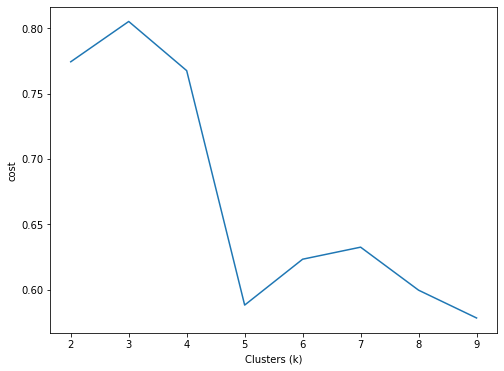

In [ ]:

#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('Clusters (k)')
ax.set_ylabel('cost')


In [ ]:

KMeans_=KMeans(featuresCol='features', k=3) 
KMeans_Model=KMeans_.fit(data_scale_output)
KMeans_Assignments=KMeans_Model.transform(data_scale_output)

centers = KMeans_Model.clusterCenters()
centers

KMeans_Assignments.show(1)

+----------------+----------+-----------------+--------------+--------------------+----------+
|count_gameclicks|count_hits|avg_price_imputed|      features|        standardized|prediction|
+----------------+----------+-----------------+--------------+--------------------+----------+
|              69|         8|              3.5|[69.0,8.0,3.5]|[0.54380637390174...|         2|
+----------------+----------+-----------------+--------------+--------------------+----------+
only showing top 1 row



In [ ]:

from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=3, inputCol="features", outputCol="prediction")
pca_model = pca.fit(data_scale_output)
pca_transformed = pca_model.transform(data_scale_output)


In [ ]:
KMeans_Assignments.show(1)

+----------------+----------+-----------------+--------------+--------------------+----------+
|count_gameclicks|count_hits|avg_price_imputed|      features|        standardized|prediction|
+----------------+----------+-----------------+--------------+--------------------+----------+
|              69|         8|              3.5|[69.0,8.0,3.5]|[0.54380637390174...|         2|
+----------------+----------+-----------------+--------------+--------------------+----------+
only showing top 1 row



/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


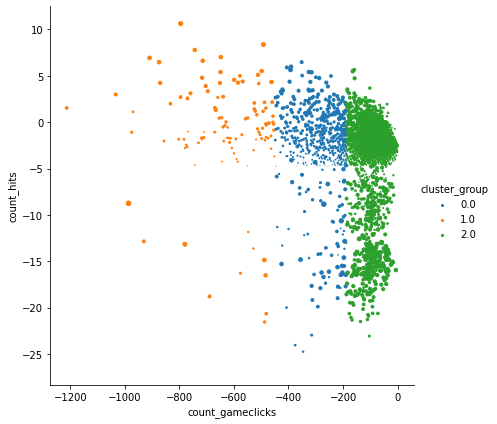

In [ ]:

import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.prediction).collect())

cluster_group = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_group))

pca_df = pd.DataFrame(data=pca_data, columns=("count_gameclicks", "count_hits","avg_price_imputed","cluster_group"))
sns.FacetGrid(pca_df,hue="cluster_group", height=6).map(plt.scatter, 'count_gameclicks', 'count_hits','avg_price_imputed' ).add_legend()

plt.show()